<a href="https://colab.research.google.com/github/sazio/NMAs/blob/main/src/LSTM_Best_Params_1_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training LSTM Architecture: Unique Net for 9 Layers - with Best Params from Weight and Biases
@authors: Simone Azeglio, Chetan Dhulipalla , Khalid Saifullah 


Part of the code here has been taken from [Neuromatch Academy's Computational Neuroscience Course](https://compneuro.neuromatch.io/projects/neurons/README.html), and specifically from [this notebook](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/projects/neurons/load_stringer_spontaneous.ipynb)

## Loading of Stringer spontaneous data



In [1]:
#@title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
    try:
        r = requests.get(url)
    except requests.ConnectionError:
        print("!!! Failed to download data !!!")
    else:
        if r.status_code != requests.codes.ok:
            print("!!! Failed to download data !!!")
        else:
            with open(fname, "wb") as fid:
                fid.write(r.content)

In [2]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

## Exploratory Data Analysis (EDA)

In [3]:
#@title Data loading
import numpy as np
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


## Extracting Data for RNN (or LFADS)
The first problem to address is that for each layer we don't have the exact same number of neurons. We'd like to have a single RNN encoding all the different layers activities, to make it easier we can take the number of neurons ($N_{neurons} = 1131$ of the least represented class (layer) and level out each remaining class. 

In [4]:
# Extract labels from z - coordinate
from sklearn import preprocessing
x, y, z = dat['xyz']

le = preprocessing.LabelEncoder()
labels = le.fit_transform(z)
### least represented class (layer with less neurons)
n_samples = np.histogram(labels, bins=9)[0][-1]

In [5]:
### Data for LFADS / RNN 
import pandas as pd 
dataSet = pd.DataFrame(dat["sresp"])
dataSet["label"] = labels 

In [6]:
# it can be done in one loop ... 
data_ = []
for i in range(0, 9):
    data_.append(dataSet[dataSet["label"] == i].sample(n = n_samples).iloc[:,:-1].values)

dataRNN = np.zeros((n_samples, dataSet.shape[1]-1, 9))
for i in range(0,9):
    
    # dataRNN[n_samples*i:n_samples*(i+1), :] = data_[i]
    ## normalized by layer
    dataRNN[:, :, i] = data_[i]/np.mean(np.asarray(data_)[i,:,:], axis = 0)



In [7]:
# functions 

def moving_avg(array, factor = 2):
    """Reducing the number of compontents by averaging of N = factor
    subsequent elements of array"""
    #zeros_ = np.zeros((array.shape[0], 2))
    #array = np.hstack((array, zeros_))
    
    array = np.reshape(array, (array.shape[0],  int(array.shape[1]/factor), factor, array.shape[2]))
    array = np.mean(array, axis = 2)

    return array

In [8]:
# downsampling and averaging 
avgd_normed_dataRNN = moving_avg(dataRNN, factor=2)

In [9]:
avgd_normed_dataRNN.shape

(1131, 3509, 9)

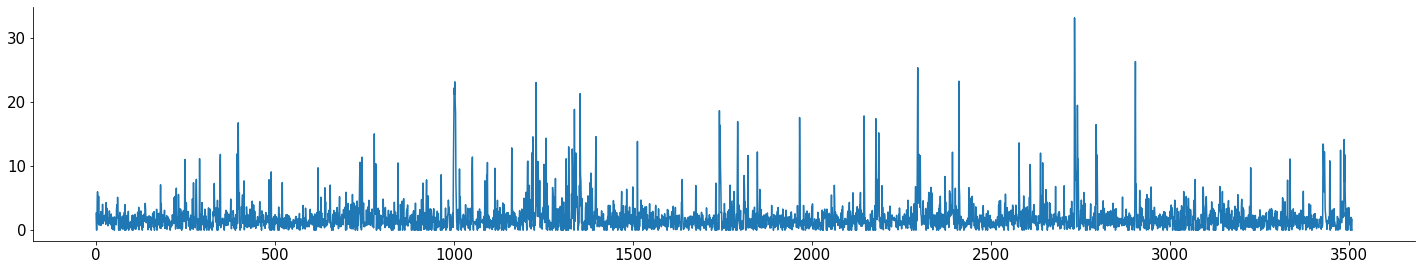

In [10]:
plt.plot(avgd_normed_dataRNN[1,:, 0])

issue: does the individual scaling by layer introduce bias that may artificially increase performance of the network?

## Data Loader 


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.cuda.empty_cache()

In [12]:
torch.__version__

'1.9.0+cu102'

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
# set the seed
np.random.seed(42)

# number of neurons 
NN = dataRNN.shape[0]

In [15]:
# swapping the axes to maintain consistency with seq2seq notebook in the following code - the network takes all the neurons at a time step as input, not just one neuron

# avgd_normed_dataRNN = np.swapaxes(avgd_normed_dataRNN, 0, 1)
avgd_normed_dataRNN.shape

(1131, 3509, 9)

In [16]:
frac = 4/5

#x1 = torch.from_numpy(dataRNN[:,:int(frac*dataRNN.shape[1])]).to(device).float().unsqueeze(0)
#x2 = torch.from_numpy(dataRNN[:,int(frac*dataRNN.shape[1]):]).to(device).float().unsqueeze(0)
#x1 = torch.from_numpy(avgd_normed_dataRNN[:1131,:]).to(device).float().unsqueeze(2)
#x2 = torch.from_numpy(avgd_normed_dataRNN[:1131,:]).to(device).float().unsqueeze(2)

#n_neurs = 1131
# let's use n_neurs/10 latent components
ncomp = 75 #int(n_neurs/10)

x1_train = torch.from_numpy(avgd_normed_dataRNN[:,:int(frac*avgd_normed_dataRNN.shape[1]), : ]).to(device).float()
x2_train = torch.from_numpy(avgd_normed_dataRNN[:,:int(frac*avgd_normed_dataRNN.shape[1]),: ]).to(device).float()

x1_valid = torch.from_numpy(avgd_normed_dataRNN[:,int(frac*avgd_normed_dataRNN.shape[1]):, :] ).to(device).float()
x2_valid = torch.from_numpy(avgd_normed_dataRNN[:,int(frac*avgd_normed_dataRNN.shape[1]):, :]).to(device).float()

NN1 = x1_train.shape[0]
NN2 = x2_train.shape[0]


In [17]:
class Net(nn.Module):
    def __init__(self, ncomp, NN1, NN2, bidi=True):
        super(Net, self).__init__()

        # play with some of the options in the RNN!
        
        self.rnn = nn.LSTM(NN1, ncomp, num_layers = 1, dropout = 0.3,
                         bidirectional = bidi)
        """
        self.rnn = nn.RNN(NN1, ncomp, num_layers = 1, dropout = 0,
                    bidirectional = bidi, nonlinearity = 'tanh')
        self.rnn = nn.GRU(NN1, ncomp, num_layers = 1, dropout = 0,
                         bidirectional = bidi)
        """
        
        self.mlp = nn.Sequential(
                    nn.Linear(ncomp, ncomp*2),
                    nn.Mish(),
                    nn.Linear(ncomp*2, ncomp*2),
                    nn.Mish(),
                    nn.Dropout(0.25),
                    nn.Linear(ncomp*2, ncomp), 
                    nn.Mish())
        
        self.fc = nn.Linear(ncomp, NN2)

    def forward(self, x):
        x = x.permute(1, 2, 0)
        #print(x.shape)
        # h_0 = torch.zeros(2, x.size()[1], self.ncomp).to(device)
        
        y, h_n = self.rnn(x)

        #print(y.shape)
        #print(h_n.shape)
        if self.rnn.bidirectional:
          # if the rnn is bidirectional, it concatenates the activations from the forward and backward pass
          # we want to add them instead, so as to enforce the latents to match between the forward and backward pass
            q = (y[:, :, :ncomp] + y[:, :, ncomp:])/2
        else:
            q = y
        
        q = self.mlp(q)

        # the softplus function is just like a relu but it's smoothed out so we can't predict 0
        # if we predict 0 and there was a spike, that's an instant Inf in the Poisson log-likelihood which leads to failure
        #z = F.softplus(self.fc(q), 10)
        #print(q.shape)
        z = self.fc(q).permute(2, 0, 1)
        # print(z.shape)
        return z, q

In [18]:
# we initialize the neural network
net = Net(ncomp, NN1, NN2, bidi = True).to(device)

# special thing:  we initialize the biases of the last layer in the neural network
# we set them as the mean firing rates of the neurons.
# this should make the initial predictions close to the mean, because the latents don't contribute much
# net.fc.bias.data[:] = x1_train.mean(axis = (0,1))

# we set up the optimizer. Adjust the learning rate if the training is slow or if it explodes.
#optimizer1 = torch.optim.Adam(net.parameters(), lr= 0.0003795, weight_decay= 10e-6)
# optimizer2 = torch.optim.SGD(net.parameters(), lr = 0.0001, momentum = 0.9, weight_decay = 0.01, )
# optimizer3 = torch.optim.

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [19]:
# forward check 
# net(x1)
net(x1_train)

(tensor([[[ 0.0264,  0.0243,  0.0226,  ...,  0.0161,  0.0247,  0.0277],
          [ 0.0217,  0.0291,  0.0340,  ...,  0.0323,  0.0254,  0.0321],
          [ 0.0277,  0.0204,  0.0317,  ...,  0.0137,  0.0123,  0.0190],
          ...,
          [ 0.0372,  0.0203,  0.0197,  ...,  0.0166,  0.0295,  0.0270],
          [ 0.0362,  0.0068,  0.0120,  ...,  0.0203,  0.0225,  0.0380],
          [ 0.0349,  0.0112,  0.0343,  ...,  0.0291,  0.0241,  0.0356]],
 
         [[-0.0509, -0.0417, -0.0363,  ..., -0.0456, -0.0503, -0.0309],
          [-0.0431, -0.0398, -0.0485,  ..., -0.0542, -0.0413, -0.0549],
          [-0.0483, -0.0355, -0.0446,  ..., -0.0443, -0.0438, -0.0453],
          ...,
          [-0.0432, -0.0429, -0.0338,  ..., -0.0419, -0.0375, -0.0406],
          [-0.0533, -0.0416, -0.0533,  ..., -0.0471, -0.0390, -0.0343],
          [-0.0474, -0.0401, -0.0412,  ..., -0.0453, -0.0385, -0.0362]],
 
         [[ 0.0296,  0.0065,  0.0104,  ...,  0.0178,  0.0268,  0.0223],
          [ 0.0153,  0.0090,

## Training 

In [ ]:
!pip3 install tqdm --quiet

In [22]:
from tqdm.notebook import tqdm
from sam import SAM

base_optimizer = torch.optim.Adam  # define an optimizer for the "sharpness-aware" update
optimizer = SAM(net.parameters(), base_optimizer, lr=0.000974, weight_decay = 0.00001)#, momentum=0.9)

# you can keep re-running this cell if you think the cost might decrease further

cost = nn.MSELoss()

#train_save = []
#valid_save = []

niter = 50000 #+30000 # 
# rnn_loss = 0.2372, lstm_loss = 0.2340, gru_lstm = 0.2370
for k in tqdm(range(niter)):
    net.train()
    # the network outputs the single-neuron prediction and the latents
    z, y = net(x1_train)

    # our cost
    loss = cost(z, x2_train)

    # train the network as usual
    loss.backward()
    optimizer.first_step(zero_grad = True)
    cost(net(x1_train)[0],x2_train).backward()
    
    optimizer.second_step(zero_grad=True)
    
    """
    # this can be run in a first phase, before wandb finetuning
    with torch.no_grad():
        net.eval()
        train_save.append(loss.item())
        valid_loss = cost(net(x1_valid)[0], x2_valid)
        valid_save.append(valid_loss.item())
    """;

    if k % 50 == 0:
        with torch.no_grad():
            net.eval()
            valid_loss = cost(net(x1_valid)[0], x2_valid)
            
            print(f' iteration {k}, train cost {loss.item():.4f}, valid cost {valid_loss.item():.4f}')

  0%|          | 1/50000 [00:01<16:17:27,  1.17s/it]

 iteration 0, train cost 3.5253, valid cost 3.6255


  0%|          | 33/50000 [00:32<13:39:01,  1.02it/s]


KeyboardInterrupt: ignored

In [ ]:
#plt.plot(train_save)
#plt.plot(valid_save)

In [ ]:
torch.save(net.state_dict(), "/home/sazeglio/NMAs/SavedModels/Unique_Net/Net_Complete.pt")

### Saving Model 

## Validation from same neurons

In [ ]:
test, hidden = net(x1_valid)

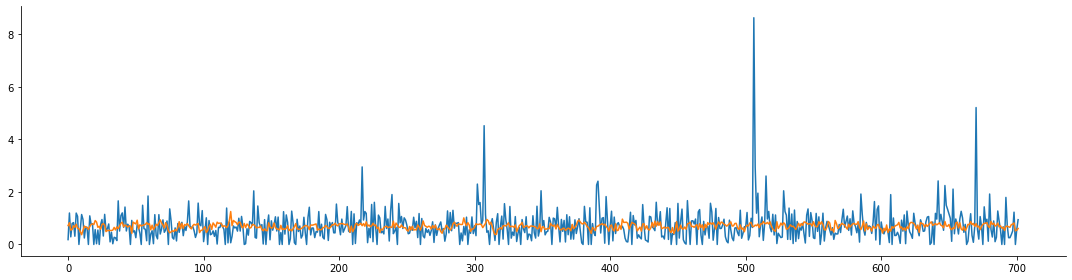

In [ ]:
%matplotlib inline
plt.figure(figsize = (15, 4))
plt.plot(x2_valid[4,:,0].cpu().detach().numpy())
plt.plot(test[4,:,0].cpu().detach().numpy())